In [13]:
# imports
import csv
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd

In [14]:
# preparation

# init environments
envs = {
    "one-agent": {"agent_amount": 1},
    "two-agents": {"agent_amount": 2},
    "two-agents-sm": {"agent_amount": 2, "market": "sm", "counter": ["two-agents", "two-agents-am","two-agents-am-goal"]},
    "two-agents-am": {"agent_amount": 2, "market": "am"},
    "two-agents-am-goal": {"agent_amount": 2, "market": "am"},
    "two-agents-sm-mixed" : {"agent_amount": 2, "mixed": True, "market": "sm", "counter": ["two-agents-mixed"]},
    "two-agents-mixed": {"agent_amount": 2, "mixed": True},
    "two-agents-percentage": {
        "agent_amount": 2, 
        "percentage":True
    },
    "two-agents-sm-percentage": {
        "agent_amount": 2, 
        "percentage":True, 
        "market": "sm",
        "counter": ["two-agents-percentage"]
    },
    "three-agents": {"agent_amount": 3},
    "five-agents": {"agent_amount": 5},
    "five-agents-percentage": {"agent_amount": 5, "percentage":True},
    "five-agents-sm": {"agent_amount": 5, "market": "sm", "counter": ["five-agents"]},
}

# init data logging 
log_data = {}

In [15]:
# helper functions

def create_dataframe():
    # read files
    df_settings_dict = {}
    for setting in envs.keys():
        try:
            df_settings_dict[setting] = pd.read_csv('storage/'+setting+'/log.csv')
            # add setting to the df columns
            df_settings_dict[setting].columns = [setting + "_" + str(col) for col in df_settings_dict[setting].columns]
        except(FileNotFoundError):
            continue
    # join all dataframes (one per setting)
    df = pd.concat([df for df in df_settings_dict.values()], axis=1)
    return df

def get_frame_col(df):
    for col in df.columns:
        if "frames" in col:
            # since frames don't differ between settings, but i.e. three agents probably 
            # needs more frames pick the column that has the most values
            # (for example check if the value of the last index is not NaN)
            last_value = df[col].iloc[-1]
            if not np.isnan(last_value) and "frames":
                return col

def get_longform(df, key, agent_specific=False):
    cols = extract_cols(df, key, agent_specific=agent_specific)
    # first create wideform
    df_wideform = df[cols].copy()
    # reshape dataframe into longform
    lf = convert_to_longform(df_wideform, key)
    return lf

def extract_cols(df, key, agent_specific=False):
    result_cols = [get_frame_col(df)]
    
    for col in df.columns:
        if not agent_specific:
            if key in col:
                result_cols.append(col)
        else:
            if key+"_agent_0" in col:
                # always safe agent 0 values
                result_cols.append(col)
            elif "mixed" in col and key in col:
                # always add mixed values for each agent since they differ from each other
                result_cols.append(col)
               
    # print(result_cols)
    return result_cols

def get_frames_col_name(df_cols):
    for col in df_cols:
        if "frames" in col:
            return col

def convert_to_longform(df, key):
    frames_col = get_frames_col_name(df.columns)
    lf_df = df.melt(id_vars=[frames_col], var_name="setting", value_name=key)
    lf_df.rename(columns={frames_col:'frames'}, inplace=True)
    return lf_df

In [16]:
df = create_dataframe()

key_mean_rewards = "mean_reward"
key_mean_trades = "mean_trades"
key_mean_reset_fields = "mean_num_reset_fields"
key_mean_grid_coloration = "mean_grid_coloration_percentage"

lf_mean_rewards = get_longform(df, key_mean_rewards, True)
lf_mean_reset_fields = get_longform(df, key_mean_reset_fields)
lf_mean_grid_coloration = get_longform(df, key_mean_grid_coloration)
lf_mean_trades = get_longform(df, key_mean_trades)

mean_reward_cols = extract_cols(df, key_mean_rewards, agent_specific=True)

<AxesSubplot:xlabel='frames', ylabel='mean_trades'>

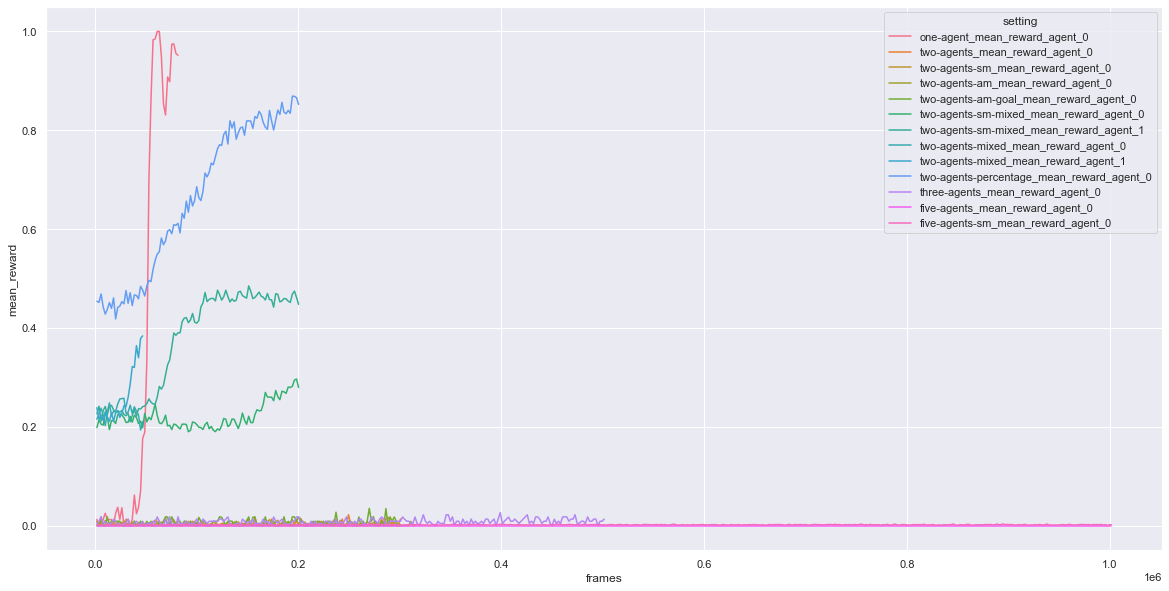

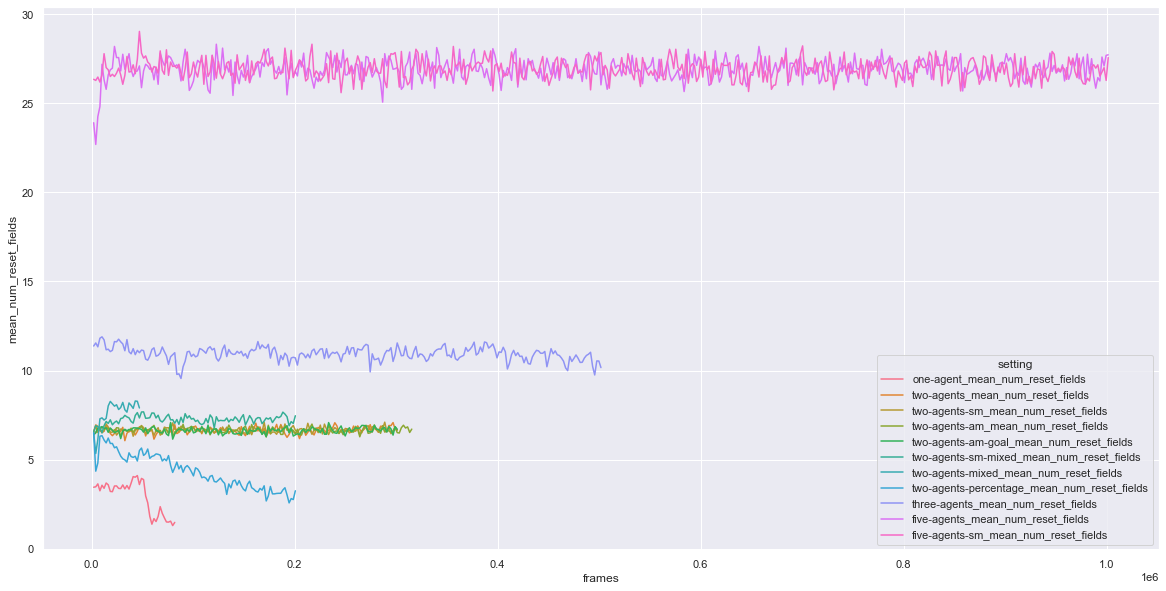

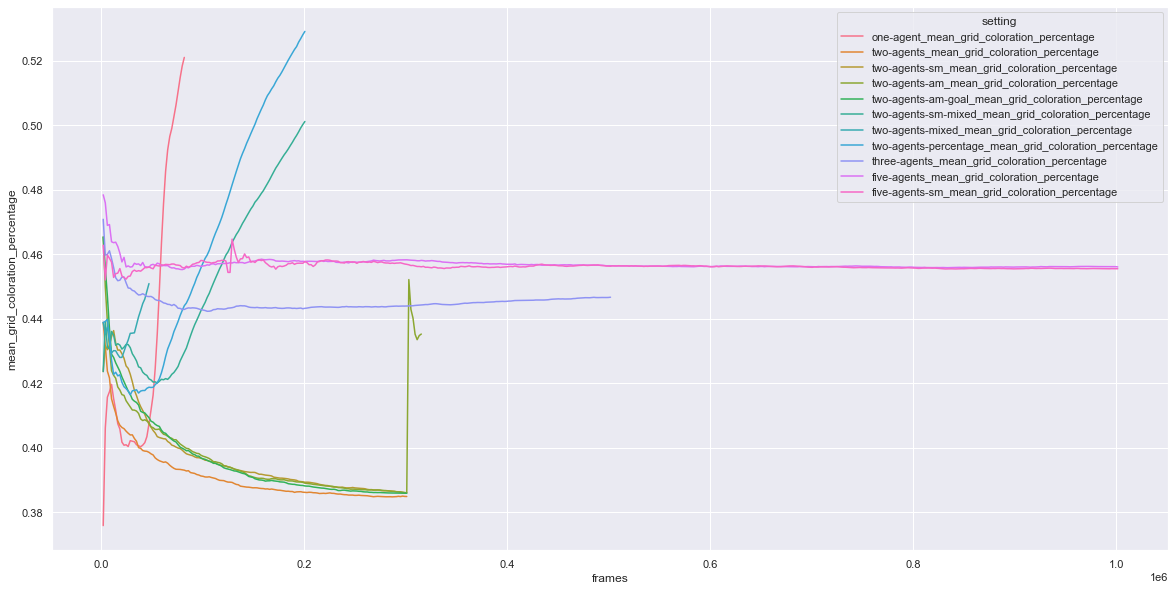

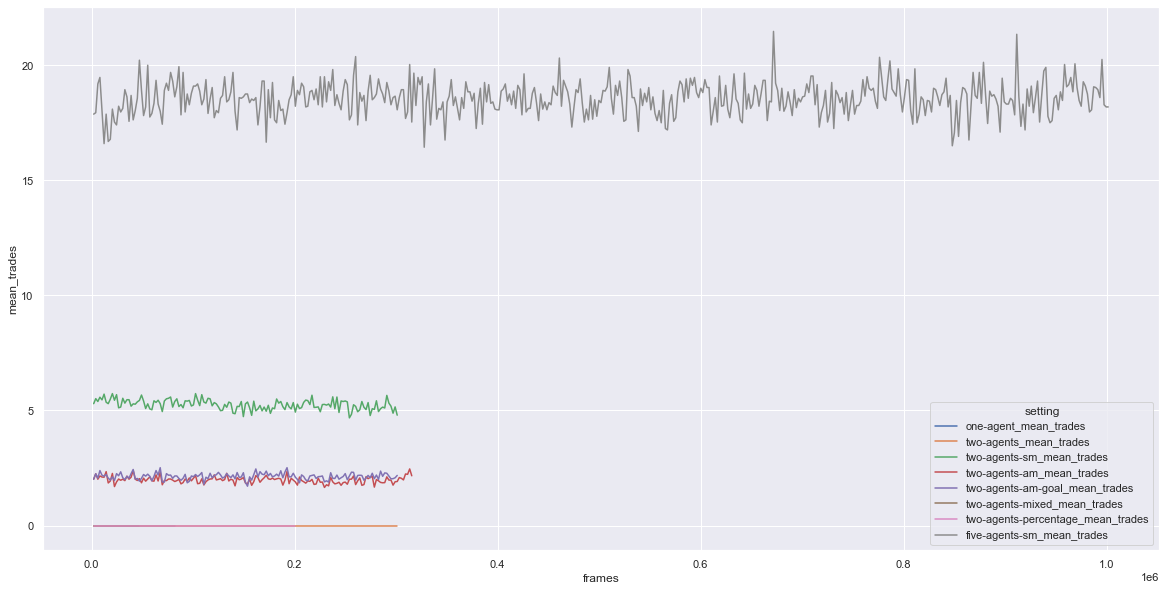

In [17]:
sns.set_theme(style="darkgrid")

plt.figure(figsize=(20,10))
# Plot the responses for different events and regions
sns.lineplot(x="frames", y=key_mean_rewards,
             hue="setting",
             data=lf_mean_rewards)

plt.figure(figsize=(20,10))
# Plot the responses for different events and regions
sns.lineplot(x="frames", y=key_mean_reset_fields,
             hue="setting",
             data=lf_mean_reset_fields)

plt.figure(figsize=(20,10))
# Plot the responses for different events and regions
sns.lineplot(x="frames", y=key_mean_grid_coloration,
             hue="setting",
             data=lf_mean_grid_coloration)

plt.figure(figsize=(20,10))
# Plot the responses for different events and regions
sns.lineplot(x="frames", y=key_mean_trades,
             hue="setting",
             data=lf_mean_trades)

Index(['frames', 'setting', 'mean_reward'], dtype='object')
Index(['frames', 'setting', 'mean_reward'], dtype='object')
Index(['frames', 'setting', 'mean_reward'], dtype='object')
Index(['frames', 'setting', 'mean_reward'], dtype='object')


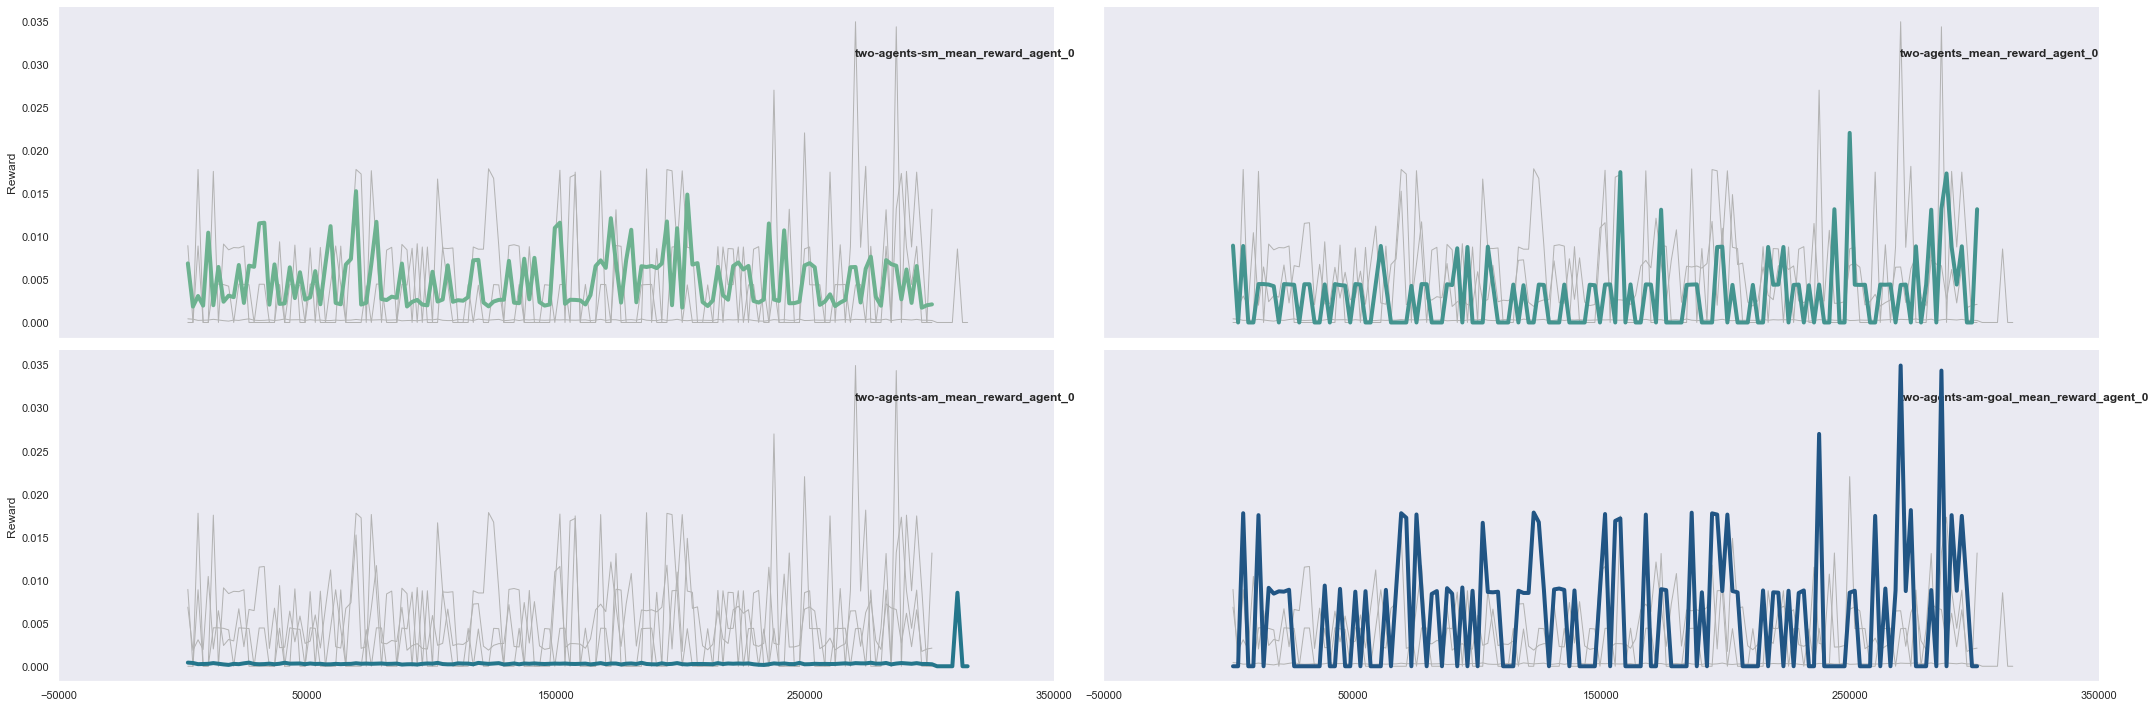

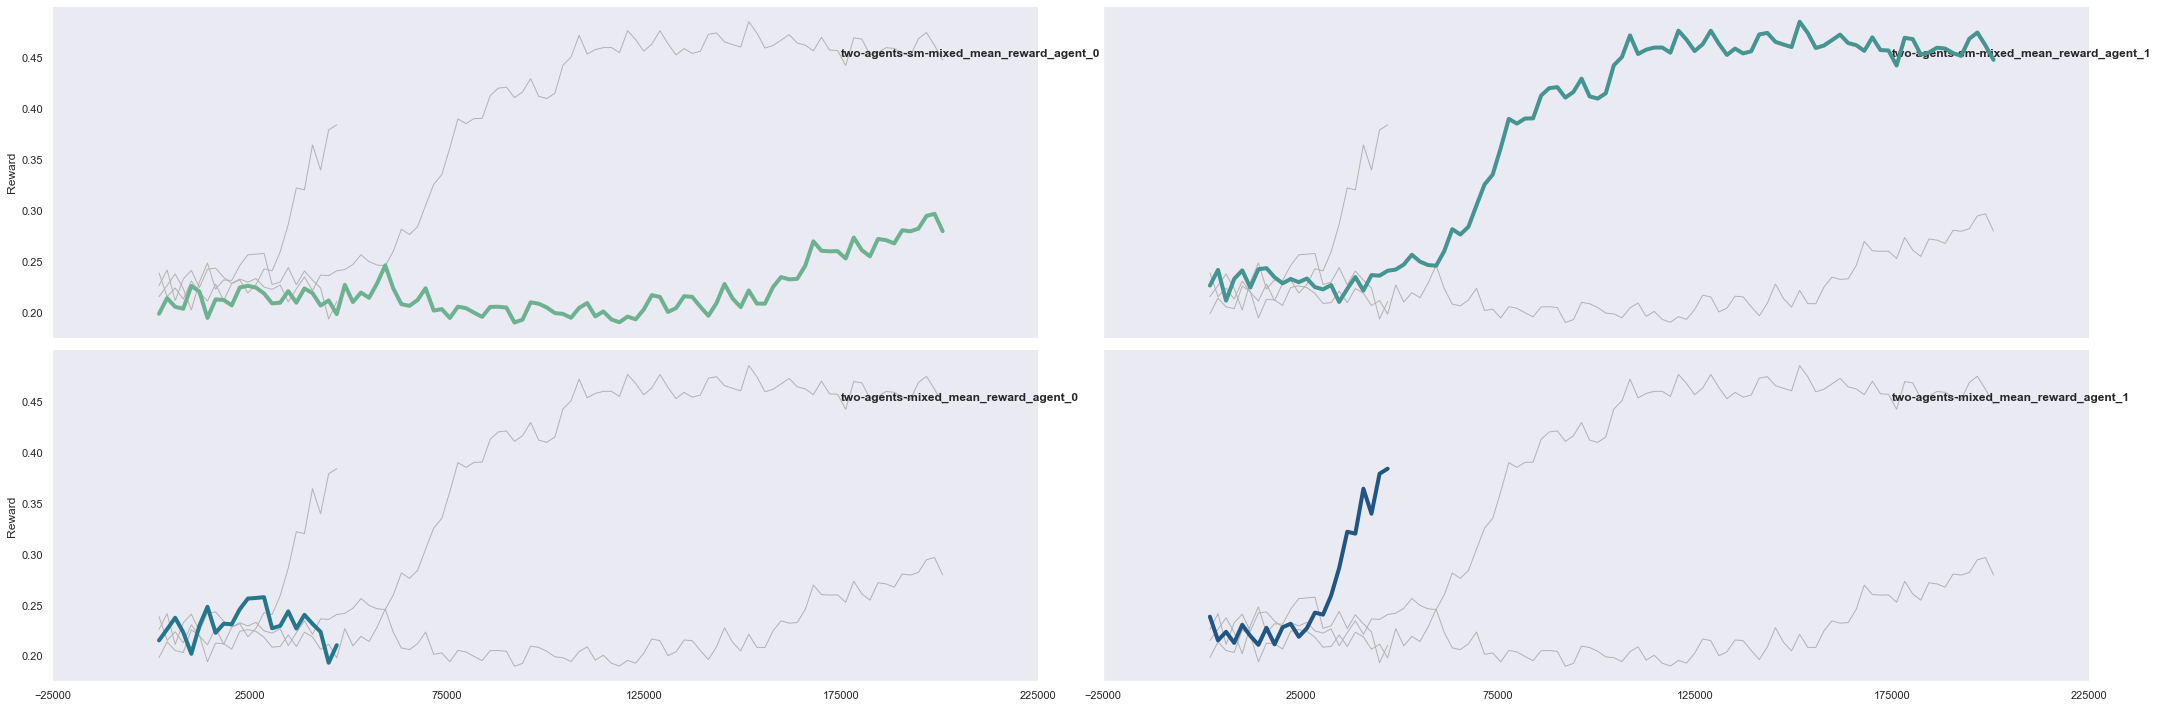

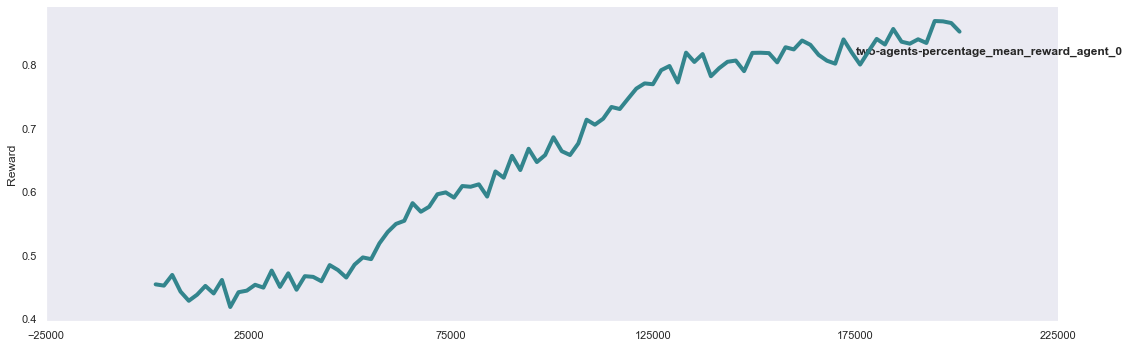

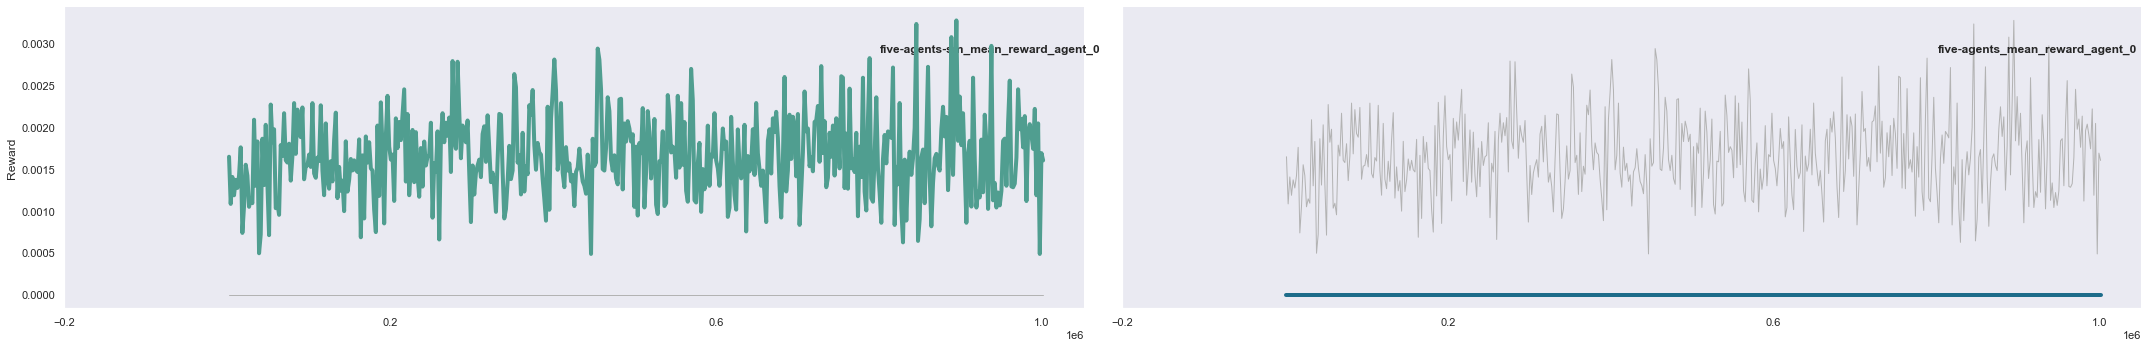

In [25]:
sns.set_theme(style="dark")

market_settings = []
for key, env_settings in envs.items():
    if "market" in env_settings and "counter" in env_settings:
        reward_cols_market = [i for i in mean_reward_cols if key+"_" in i]
        reward_cols_market_counter = [i for i in mean_reward_cols for counter in env_settings["counter"] if counter+"_" in i]
        market_settings.append(reward_cols_market + reward_cols_market_counter)


for index, setting in enumerate(market_settings):
    if not any("frames" in setting_col for setting_col in setting):
        setting.append(get_frame_col(df))
    df_market = df[setting].copy()
    lf_market = convert_to_longform(df_market, key_mean_rewards)
    print(lf_market.columns)
    # sns.set_theme(style="darkgrid")

    # Plot each year's time series in its own facet
    g = sns.relplot(
        data=lf_market,
        x="frames", y=key_mean_rewards, col="setting", hue="setting",
        kind="line", palette="crest", linewidth=4, zorder=5,
        col_wrap=2, height=5, aspect=3, legend=False,
    )

    # Iterate over each subplot to customize further
    for s, ax in g.axes_dict.items():

        # Add the title as an annotation within the plot
        ax.text(.8, .85, s, transform=ax.transAxes, fontweight="bold")

        # Plot every year's time series in the background
        sns.lineplot(
            data=lf_market, x="frames", y=key_mean_rewards, units="setting",
            estimator=None, color=".7", linewidth=1, ax=ax,
        )

    # Reduce the frequency of the x axis ticks
    ax.set_xticks(ax.get_xticks()[::2])

    # Tweak the supporting aspects of the plot
    g.set_titles("")
    g.set_axis_labels("", "Reward")
    g.tight_layout()

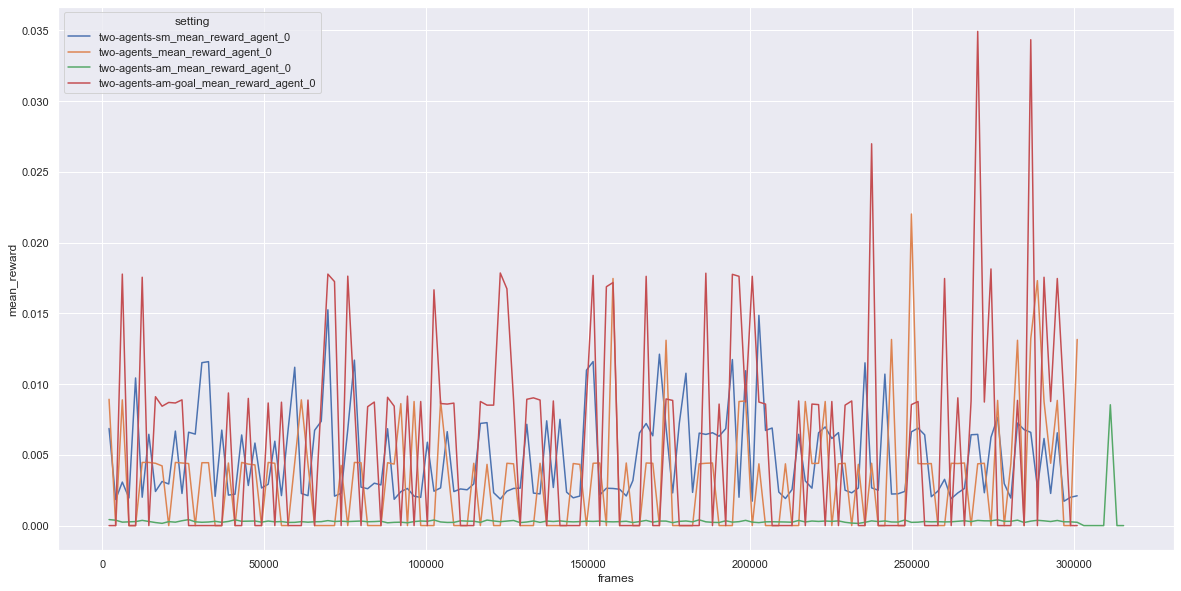

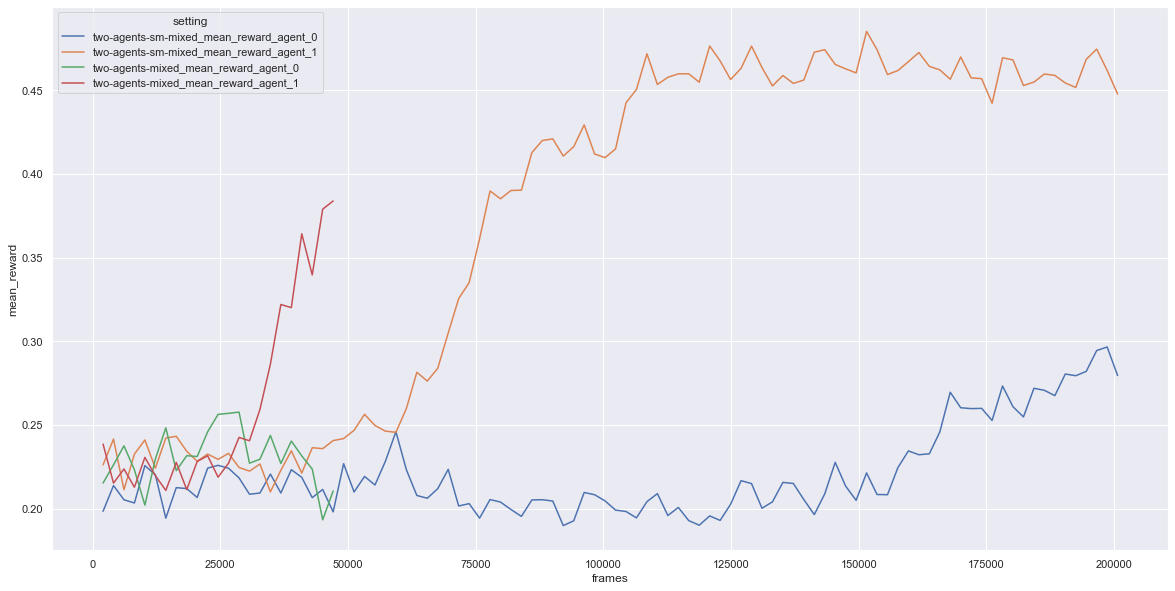

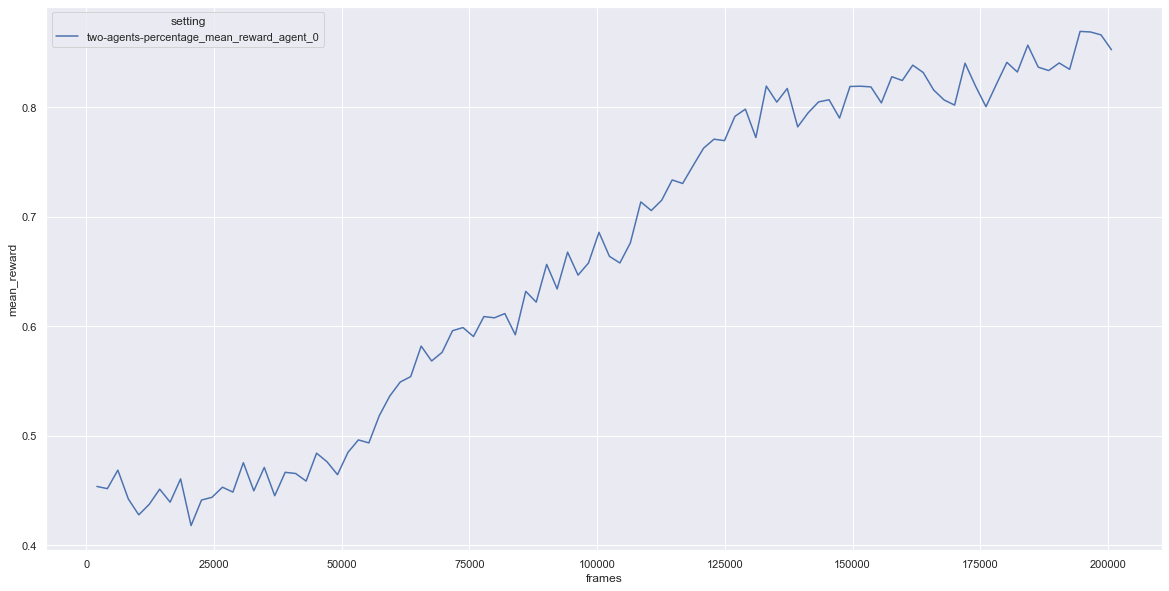

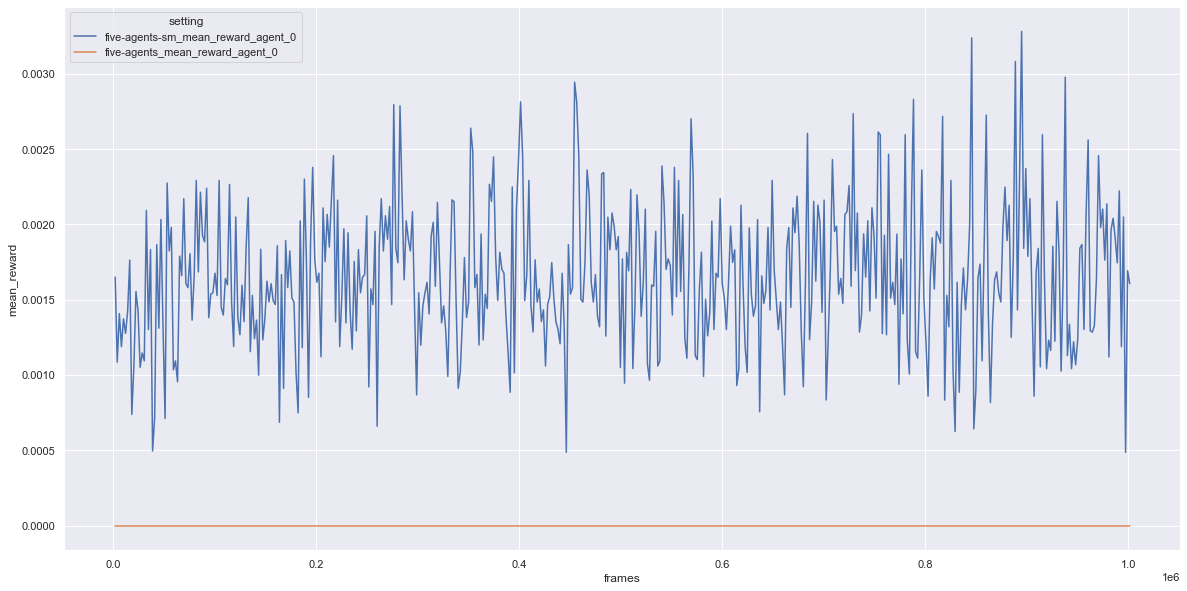

In [18]:
market_settings = []
for key, env_settings in envs.items():
    if "market" in env_settings and "counter" in env_settings:
        reward_cols_market = [i for i in mean_reward_cols if key+"_" in i]
        reward_cols_market_counter = [i for i in mean_reward_cols for counter in env_settings["counter"] if counter+"_" in i]
        market_settings.append(reward_cols_market + reward_cols_market_counter)


for index, setting in enumerate(market_settings):
    if not any("frames" in setting_col for setting_col in setting):
        setting.append(get_frame_col(df))
    df_market = df[setting].copy()
    lf_market = convert_to_longform(df_market, key_mean_rewards)
    # sns.set_theme(style="darkgrid")

    plt.figure(index, figsize=(20,10))
    # Plot the responses for different events and regions
    sns.lineplot(x="frames", y=key_mean_rewards,
                hue="setting",
                data=lf_market)